# Lab 10 -- Decision Trees for Regression

Compared to last week, this is a very simple lab <span style="font-size:20pt;">😃</span> You'll have fun programming!

You will implement the **Classification and Regression Tree (CART)** algorithm from scratch.

The lab is broken down into the following pieces:

* Regression Criterion
* Creating Splits
* Buiding a Tree
* Making a prediction

## Exercise 1 -- Download and load the dataset

We will be using the usual Boston Housing dataset, which is available to download from ECLASS

* Download the file
* Read it and separate the target variable from the features.
* Make a 80/10/10 train/validation/test split

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [25]:
# your code here

data = pd.read_csv("BostonHousing.txt")

The target variable will be as usual `MEDV`. Use the rest as features.

In [26]:
# your code here

y = data["medv"].to_numpy()
X = data.drop("medv", axis = 1).to_numpy()

X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size = 0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size = 1/9)

## Exercise 2 -- Optimization Criterion

For regression, a simple criterion to optimize is to minimize the sum of squared errors for a given region. This is, for all datapoints in a region with size, we minimize:

$$\sum_{i=1}^N(y_i - \hat{y})^2$$

where $N$ is the number of datapoits in the region and $\hat{y}$ is the mean value of the region for the target variable. 

Implement such a function using the description below.

Please, don't use an existing implementation, refer to the [book](https://www.statlearning.com/s/ISLRSeventhPrinting.pdf), and if you need help, ask questions!

In [27]:
def regression_criterion(region):
    """
    Implements the sum of squared error criterion in a region
    
    Parameters
    ----------
    region : ndarray
        Array of shape (N,) containing the values of the target values 
        for N datapoints in the training set.
    
    Returns
    -------
    float
        The sum of squared error
        
    Note
    ----
    The error for an empty region should be infinity (use: float("inf"))
    This avoids creating empty regions
    """
    # Se a região for vazia, o erro é infinito
    if region.size == 0:
        return float("inf")
    
    # Calculando a média da região
    y_hat = np.mean(region)
    # Calculando o erro da região
    region_error = np.sum((region - y_hat)**2)

    return region_error

In [28]:
# test your code
rng = np.random.default_rng(0)
print(regression_criterion(rng.random(size=40)))
print(regression_criterion(np.ones(10)))
print(regression_criterion(np.zeros(10)))
print(regression_criterion(np.array([])))

3.6200679838629544
0.0
0.0
inf


## Exercise 3 -- Make a split

In [29]:
def split_region(region, feature_index, tau):
    """
    Given a region, splits it based on the feature indicated by
    `feature_index`, the region will be split in two, where
    one side will contain all points with the feature with values 
    lower than `tau`, and the other split will contain the 
    remaining datapoints.
    
    Parameters
    ----------
    region : array of size (n_samples, n_features)
        a partition of the dataset (or the full dataset) to be split
    feature_index : int
        the index of the feature (column of the region array) used to make this partition
    tau : float
        The threshold used to make this partition
        
    Return
    ------
    left_partition : array
        indices of the datapoints in `region` where feature < `tau`
    right_partition : array
        indices of the datapoints in `region` where feature >= `tau` 
    """
    # your code here
    
    # Array de booleanos para filtrar os registros
    split = region[:, feature_index] < tau
    # Array com os índices dos registros nessa região
    indices = np.array(range(region.shape[0]))

    # Encontrando as partições
    left_partition = indices[split]
    right_partition = indices[~split]

    return left_partition, right_partition

In [30]:
l, r = split_region(X_train, 2, 10)
print(l.shape, r.shape)

(217,) (187,)


## Exercise 4 -- Find the best split

The strategy is quite simple (as well as inefficient), but it helps to reinforce the concepts.
We are going to use a greedy, exhaustive algorithm to select splits, selecting the `feature_index` and the `tau` that minimizes the Regression Criterion

In [31]:
def get_split(X, y):
    """
    Given a dataset (full or partial), splits it on the feature of that minimizes the sum of squared error
    
    Parameters
    ----------
    X : array (n_samples, n_features)
        features 
    y : array (n_samples, )
        labels
    
    Returns
    -------
    decision : dictionary
        keys are:
        * 'feature_index' -> an integer that indicates the feature (column) of `X` on which the data is split
        * 'tau' -> the threshold used to make the split
        * 'left_region' -> array of indices where the `feature_index`th feature of X is lower than `tau`
        * 'right_region' -> indices not in `low_region`
    """
    # your code here

    # Inicializando as melhores configurações de divisão
    best_feature = 0
    best_tau = 0
    best_criterion = float("inf")

    # Para cada feature...
    for feature in range(X.shape[1]):
        # Cria a lista dos taus a serem testados, sendo os valores desses dados para essa feature
        # adicionado com um valor maior que todos eles
        taus = np.unique(X[:, feature])
        taus = np.append(taus, np.max(taus) + 1)

        # Para cada tau...
        for tau in taus:
            # Divide a região
            left, right = split_region(X, feature, tau)
            # Calcula o criterion somando os criterions das duas regiões criadas
            criterion = regression_criterion(y[left]) + regression_criterion(y[right])

            # Se esse criterion for menor que o melhor até agora...
            if criterion < best_criterion:
                # Atualiza as melhores configurações para essa
                best_feature = feature
                best_tau = tau
                best_criterion = criterion

    # Dividindo a região com as melhores configurações
    left_region, right_region = split_region(X, best_feature, best_tau)

    # Criando o dicionário com as informações solicitadas
    decision = {"feature_index": best_feature, "tau": best_tau, "left_region": left_region, "right_region": right_region}

    return decision

In [32]:
get_split(X_train[:15, :], y_train[:15])

{'feature_index': 5,
 'tau': 7.016,
 'left_region': array([ 0,  1,  2,  4,  5,  6,  7,  9, 11, 12, 13, 14]),
 'right_region': array([ 3,  8, 10])}

In [33]:
k = 20
test_root = get_split(X_train[:k, :], y_train[:k])
# recursive_growth(test_root, 5, 3, 1, X_train[:k, :], y_train[:k])

## Exercise 5 -- Recursive Splitting

The test above is an example on how to find the root node of our decision tree. The algorithm now is a greedy search until we reach a stop criterion. To find the actual root node of our decision tree, you must provide the whole training set, not just a slice of 15 rows as the test above.

The trivial stopping criterion is to recursively grow the tree until each split contains a single point (perfect node purity). If we go that far, it normally means we are overfitting.

You will implement these criteria to stop the growth:

* A node is a leaf if:
    * It has less than `min_samples` datapoints
    * It is at the `max_depth` level from the root (each split creates a new level)
    * The criterion is `0`



In [34]:
def recursive_growth(node, min_samples, max_depth, current_depth, X, y):
    """
    Recursively grows a decision tree.
    
    Parameters
    ----------
    node : dictionary
        If the node is terminal, it contains only the "value" key, which determines the value to be used as a prediction.
        If the node is not terminal, the dictionary has the structure defined by `get_split`
    min_samples : int
        parameter for stopping criterion if a node has <= min_samples datapoints
    max_depth : int
        parameter for stopping criterion if a node belongs to this depth
    current_depth : int
        current distance from the root
    X : array (n_samples, n_features)
        features (full dataset)
    y : array (n_samples, )
        labels (full dataset)
    
    Notes
    -----
    To create a terminal node, a dictionary is created with a single "value" key, with a value that
    is the mean of the target variable
    
    'left' and 'right' keys are added to non-terminal nodes, which contain (possibly terminal) nodes 
    from higher levels of the tree:
    'left' corresponds to the 'left_region' key, and 'right' to the 'right_region' key
    """
    # your code here

    # Para cada região...
    for region in ["left_region", "right_region"]:
        # Pega os índices dos registros dessa região
        region_indices = node[region]
        # Se algum dos critérios de parada for atendido...
        if region_indices.size <= min_samples or current_depth == max_depth or regression_criterion(y[region_indices]) == 0:
            # Esse nó é uma folha e passa a armazenar apenas seu valor
            new_node = {"value": np.mean(y[region_indices])}
        # Se não...
        else:
            # Faz uma nova divisão
            new_node = get_split(X[region_indices], y[region_indices])
            # E começa a crescer recursivamente a partir desse nó
            recursive_growth(new_node, min_samples, max_depth, current_depth + 1, X[region_indices], y[region_indices])

        # Se estamos falando da região da esquerda...
        if region == "left_region":
            # Adiciona esse novo nó como o filho da esquerda do nó atual
            node['left'] = new_node
        # Se não...
        else:
            # Adiciona-o como o filho da direita
            node['right'] = new_node

In [35]:
# fill in the gaps with your code
min_samples = 5
max_depth = 3
root = get_split(X_train, y_train)
recursive_growth(root, min_samples, max_depth, 1, X_train, y_train)

Below we provide code to visualise the generated tree!

In [36]:
def print_tree(node, depth):
    if 'value' in node.keys():
        print('.  '*(depth-1), f"[{node['value']}]")
    else:
        print('.  '*depth, f'X_{node["feature_index"]} < {node["tau"]}')
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)

In [37]:
print_tree(root, 0)

 X_5 < 6.943
.   X_12 < 14.33
.  .   X_7 < 1.413
.  .   [44.475]
.  .   [22.916666666666668]
.  .   X_4 < 0.609
.  .   [18.260416666666668]
.  .   [12.63764705882353]
.   X_5 < 7.454
.  .   X_0 < 8.24809
.  .   [33.36842105263158]
.  .   [16.4]
.  .   X_0 < 3.47428
.  .   [45.54545454545454]
.  .   [21.9]


# Exercise 6 -- Make a Prediction
Use the a node to predict the class of a compatible dataset

In [38]:
def predict_sample(node, sample):
    """
    Makes a prediction based on the decision tree defined by `node`
    
    Parameters
    ----------
    node : dictionary
        A node created one of the methods above
    sample : array of size (n_features,)
        a sample datapoint
    """
    # your code here

    # Enquanto não chegar a uma folha...
    while "value" not in node.keys():
        # Se o valor desse datapoint para a feature desse nó for menor que o limiar desse nó...
        if sample[node["feature_index"]] < node["tau"]:
            # Vai para o nó da esquerda
            node = node["left"]
        # Se não...
        else:
            # Vai para o da direita
            node = node["right"]

    # A previsão é o valor da folha alcançada
    pred = node["value"]

    return pred

        
def predict(node, X):
    """
    Makes a prediction based on the decision tree defined by `node`
    
    Parameters
    ----------
    node : dictionary
        A node created one of the methods above
    X : array of size (n_samples, n_features)
        n_samples predictions will be made
    """
    # your code here

    # Número de dados
    n_of_datapoints = X.shape[0]

    # Array para armazenar as previsões
    y_pred = np.zeros(n_of_datapoints)

    # Para cada dado...
    for datapoint in range(n_of_datapoints):
        # Faz sua previsão e armazena-a no array
        pred = predict_sample(node, X[datapoint])
        y_pred[datapoint] = pred

    return y_pred

Now use the functions defined above to calculate the RMSE of the validation set. 
* Try first with `min_samples=20` and `max_depth=6` (for this values you should get a validation RMSE of ~8.8)

Then, experiment with different values for the stopping criteria.

In [39]:
# your code here

# Função para calcular o RMSE
def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true)**2).mean())

In [40]:
# Gerando a árvore
root = get_split(X_train, y_train)
recursive_growth(root, 20, 6, 1, X_train, y_train)

# Calculando a previsão no conjunto de validação
y_val_pred = predict(root, X_val)
# Calculando o erro
val_rmse = rmse(y_val, y_val_pred)

print("RMSE on validation: ", val_rmse)

RMSE on validation:  3.6153521285533397


In [41]:
# Matriz para armazenar os erros
errors = np.zeros((9, 9))

# Valores de teste para o mínimo de dados por folha e para a máxima profundidade
min_samples = range(0, 41, 5)
max_depths = range(2, 11)

# Para cada configuração...
for i in range(9):
    for j in range(9):
        # Gera a árvore
        root = get_split(X_train, y_train)
        recursive_growth(root, min_samples[i], max_depths[j], 1, X_train, y_train)
        # Calcula a previsão no conjunto de validação
        y_val_pred = predict(root, X_val)
        # Calcula o erro e salva na matriz
        val_rmse = rmse(y_val, y_val_pred)
        errors[i, j] = val_rmse

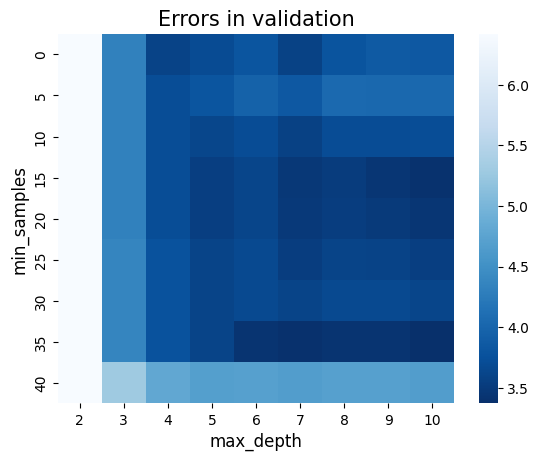

In [48]:
# Plotando o heatmap
ax = sns.heatmap(errors, xticklabels = max_depths, yticklabels = min_samples, cmap = "Blues_r")
ax.set_title('Errors in validation', fontsize=15)
ax.set_xlabel('max_depth', fontsize=12)
ax.set_ylabel('min_samples', fontsize=12)

plt.show()